In [2]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np

import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from numba import jit

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tqdm import notebook as tqdm

Prepare data

In [2]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
P = 5000 #train
P_test = P

X = X_raw[:P+P_test]
y = (2*(y_raw.astype(int) % 2) - 1)[:P+P_test].reshape(-1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=P_test, random_state=42)

In [5]:
from sklearn.decomposition import PCA
d = 20
pca = PCA(n_components = d)
pca = pca.fit(X_train)

In [6]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# project to hyper-sphere of radius sqrt(d)
X_train = np.sqrt(d) * X_train / np.linalg.norm(X_train, axis = 1, keepdims=True)
X_test = np.sqrt(d) * X_test / np.linalg.norm(X_test, axis = 1, keepdims=True)

Prepare network

In [975]:
N = int(1.1*P)

In [976]:
nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(d),
    tf.keras.layers.Dense(N, use_bias=False),
    tf.keras.layers.Activation('tanh')
])

linear_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(N),
    tf.keras.layers.Dense(1, use_bias=False, kernel_initializer='glorot_normal'),
])

In [977]:
train_features = nonlinear_model(X_train)
test_features = nonlinear_model(X_test)

In [9]:
from sklearn.svm import LinearSVC as SVM

In [979]:
svm = SVM(penalty='l2', loss='squared_hinge', fit_intercept=False, dual=False, C=1e15)

In [980]:
svm = svm.fit(train_features, y_train)

Text(0.5, 1.0, 'Train: 100% accuracy')

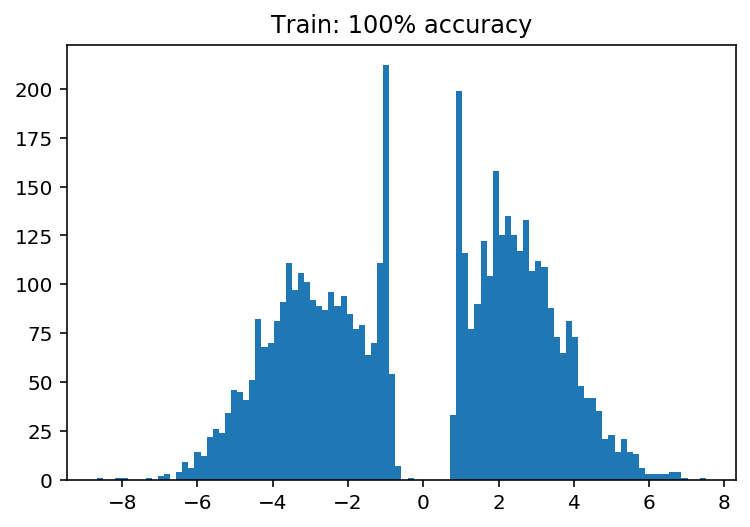

In [981]:
p = svm.decision_function(train_features)
acc = svm.score(train_features, y_train)
plt.hist(p, bins = 100)
plt.title(f'Train: {acc*100:.0f}% accuracy')

Text(0.5, 1.0, 'Test: 96% accuracy')

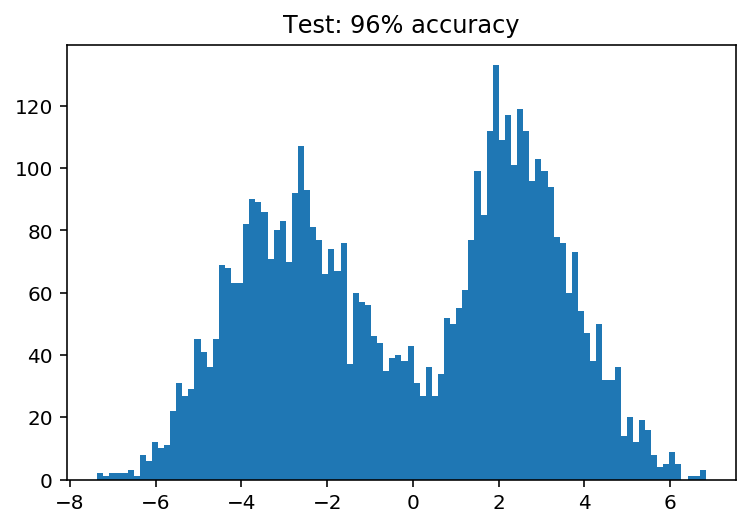

In [982]:
p = svm.decision_function(test_features)
acc = svm.score(test_features, y_test)
plt.hist(p, bins = 100)
plt.title(f'Test: {acc*100:.0f}% accuracy')

In [989]:
batch_size = min(1024, P//2)

#Initialize with SVM weights
# linear_model.layers[0].set_weights([svm.coef_.T])

#Initialize *near* SVM weights
linear_model.layers[0].set_weights([svm.coef_.T + np.random.randn(*svm.coef_.T.shape)/np.sqrt(N)])

linear_model.compile(loss='squared_hinge', optimizer='adam')
train_data = (
    tf.data.Dataset.from_tensor_slices(
        (train_features, y_train.reshape(-1,1).astype(float))
    )
    .shuffle(buffer_size=min(5*batch_size,P))
    .repeat()
    .batch(batch_size, drop_remainder=True)
)

In [990]:
n_steps = 500

losses = []
for batch in tqdm.tqdm(train_data.take(n_steps), total=n_steps):
    out = linear_model.train_step(batch)
    losses.append(out['loss'].numpy())

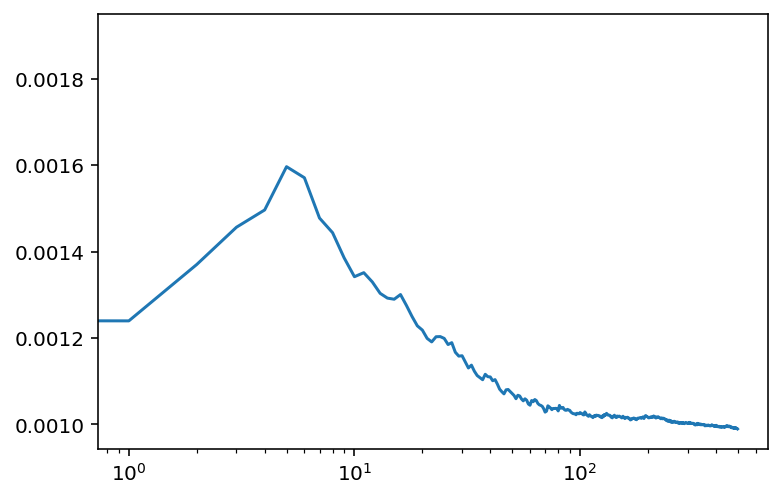

In [996]:
plt.plot(losses)
plt.xscale('log')
# plt.yscale('log')

Text(0.5, 1.0, 'Train: 100% accuracy')

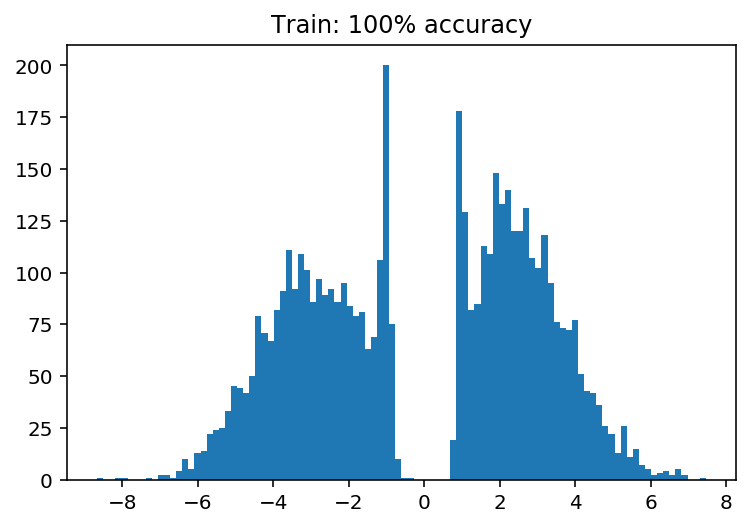

In [992]:
p = linear_model(train_features).numpy().ravel()
acc = np.mean(p*y_train > 0)
plt.hist(p, bins = 100)
plt.title(f'Train: {acc*100:.0f}% accuracy')

Text(0.5, 1.0, 'Test: 96% accuracy')

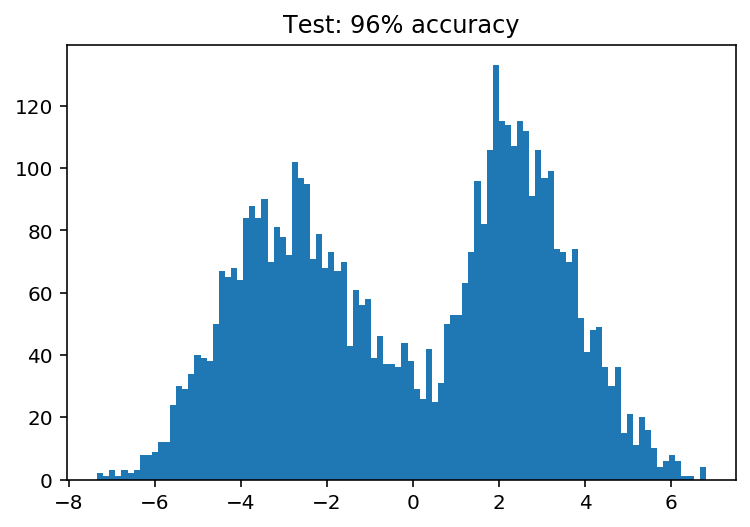

In [993]:
p = linear_model(test_features).numpy().ravel()
acc = np.mean(p*y_test > 0)
plt.hist(p, bins = 100)
plt.title(f'Test: {acc*100:.0f}% accuracy')

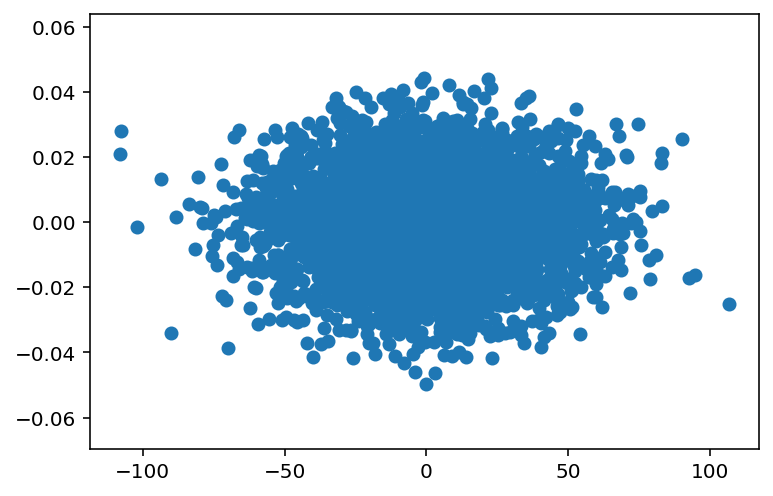

In [994]:
plt.scatter(svm.coef_.T.ravel(), svm.coef_.T.ravel() - linear_model.layers[0].get_weights()[0].ravel())

## Train loop

In [73]:
results = []
Ns = np.unique(np.logspace(0, np.log10(1.1*P)).astype(int))
for N in tqdm.tqdm(Ns):
    N = int(N)
    
    nonlinear_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(d),
        tf.keras.layers.Dense(N, use_bias=False),
        tf.keras.layers.Activation('tanh')
    ])

    linear_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(N),
        tf.keras.layers.Dense(1, use_bias=False, kernel_initializer='glorot_normal'),
    ])
    
    train_features = nonlinear_model(X_train)
    test_features = nonlinear_model(X_test)
    
    for lamb in [1e-13, 0]:
        svm = SVM(penalty='l2', loss='squared_hinge', fit_intercept=False, dual=False, C=1/max(lamb, 1e-13))
        svm = svm.fit(train_features, y_train)

        if lamb > 0:
            #Initialize NN with SVM weights
            linear_model.layers[0].set_weights([svm.coef_.T])

        else:
            #Initialize NN *near* SVM weights, and we will fine tune with no regularization
            linear_model.layers[0].set_weights([svm.coef_.T + np.random.randn(*svm.coef_.T.shape)/np.sqrt(N)])

            linear_model.compile(loss='squared_hinge', optimizer='adam')
            n_steps = 500
            batch_size = min(1024, P//2)
            train_data = (
                tf.data.Dataset.from_tensor_slices(
                    (train_features, y_train.reshape(-1,1).astype(float))
                )
                .shuffle(buffer_size=min(5*batch_size,P))
                .repeat()
                .batch(batch_size, drop_remainder=True)
            )
            for batch in tqdm.tqdm(train_data.take(n_steps), total=n_steps, leave=False):
                linear_model.train_step(batch)

        p_train = linear_model(train_features).numpy().ravel()
        p_test = linear_model(test_features).numpy().ravel()

        result = {
            'N': N,
            'P': P,
            'lambda': lamb,
            'y_train': y_train.reshape(-1),
            'y_train_hat': np.array(p_train).reshape(-1),
            'y_test': y_test.reshape(-1),
            'y_test_hat': np.array(p_test).reshape(-1)
        }

        results.append(result)

In [3]:
import pandas as pd

In [4]:
# result_df = pd.DataFrame(results)
# result_df.to_pickle('results/mnist_hinge_CK_zero_reg.pkl')

In [5]:
result_df = pd.read_pickle('results/mnist_hinge_CK_zero_reg.pkl')

In [6]:
force = lambda y,f: 1 - y*f
loss = lambda y,f: np.mean(np.maximum(0, force(y,f))**2)
N_del = lambda y,f: np.sum(force(y,f) >= 0)
N_correct = lambda y,f: np.sum(y*f > 0)
N_incorrect = lambda y,f: np.sum(y*f < 0)

In [7]:
result_df['test_loss'] = np.vectorize(loss)(result_df.y_test, result_df.y_test_hat)
result_df['train_loss'] = np.vectorize(loss)(result_df.y_train, result_df.y_train_hat)
result_df['N_del'] = np.vectorize(N_del)(result_df.y_train, result_df.y_train_hat)

result_df['N/P'] = result_df['N']/result_df['P']
result_df['P/N'] = result_df['P']/result_df['N']
result_df['N_del/P'] = result_df['N_del']/result_df['P']
result_df['N_del/N'] = result_df['N_del']/result_df['N']

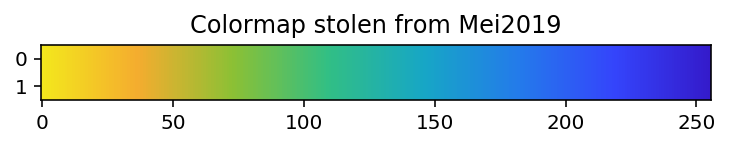

In [8]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'Mei2019', 
    np.array([
        (243, 232, 29),
        (245, 173, 47),
        (140, 193, 53),
        (50,  191, 133),
        (23,  167, 198),
        (36,  123, 235),
        (53,  69,  252),
        (52,  27,  203)
    ])/255., 
)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(6,.5))
img = plt.imshow(gradient, aspect='auto', cmap=cmap)
title = plt.title('Colormap stolen from Mei2019')

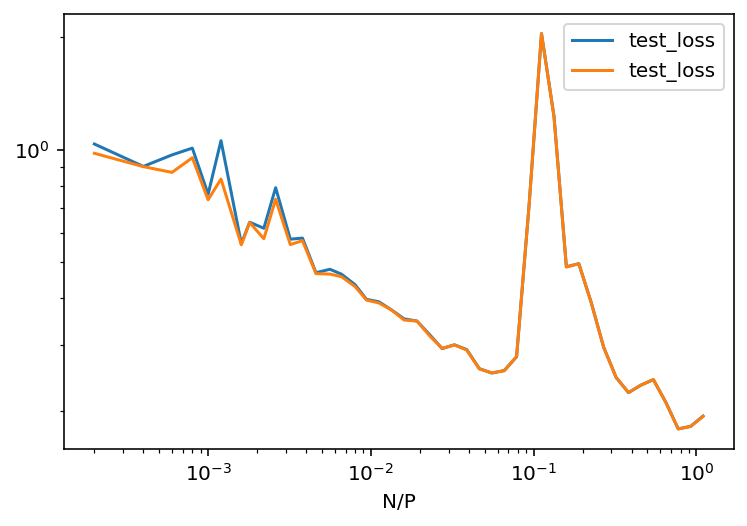

In [9]:
fig, ax = plt.subplots()
result_df[result_df['lambda'] == 0].plot('N/P', 'test_loss', ax=ax)
result_df[result_df['lambda'] != 0].plot('N/P', 'test_loss', ax=ax)
plt.yscale('log')
plt.xscale('log')

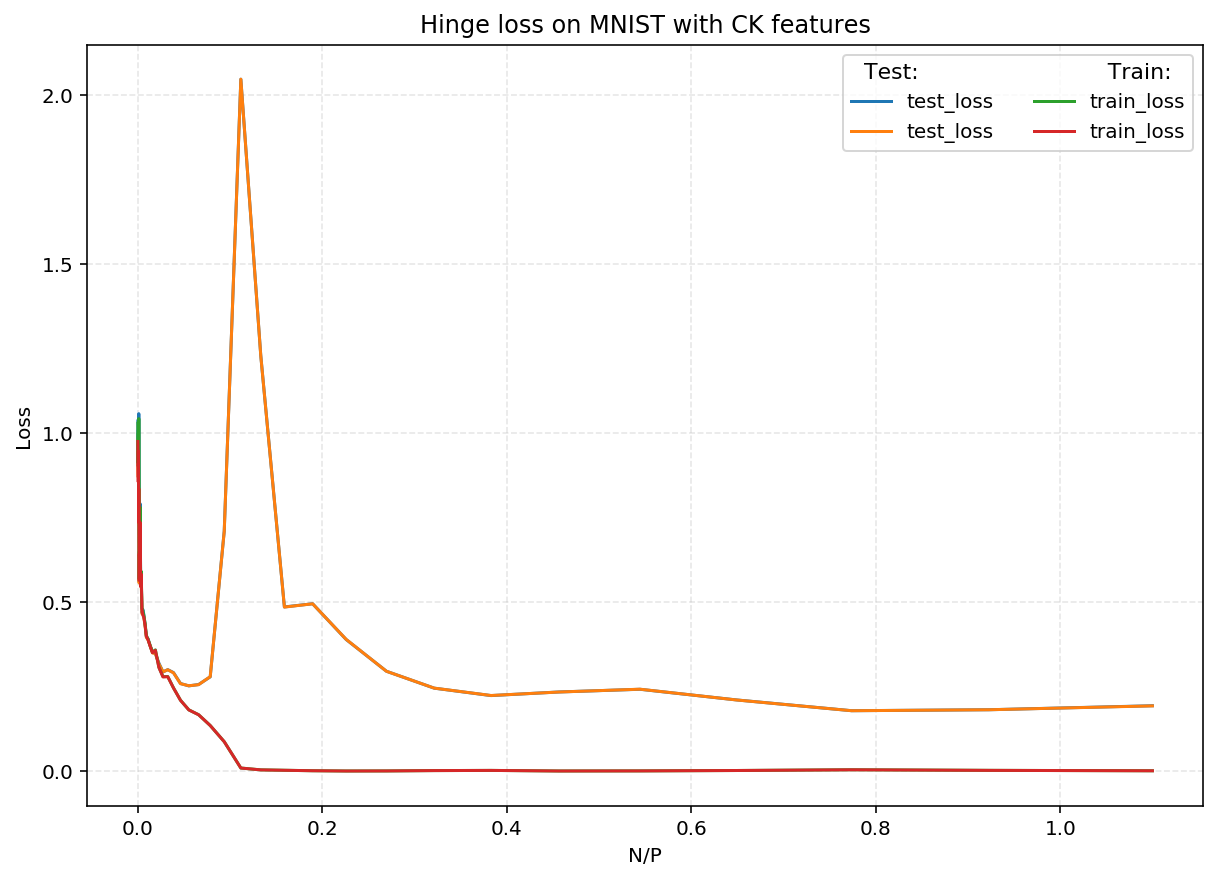

In [10]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'test_loss', ax=ax)
#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'train_loss',ax=ax)
    
ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')

fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

Text(0.5, 1.0, 'Hinge loss on MNIST with CK features')

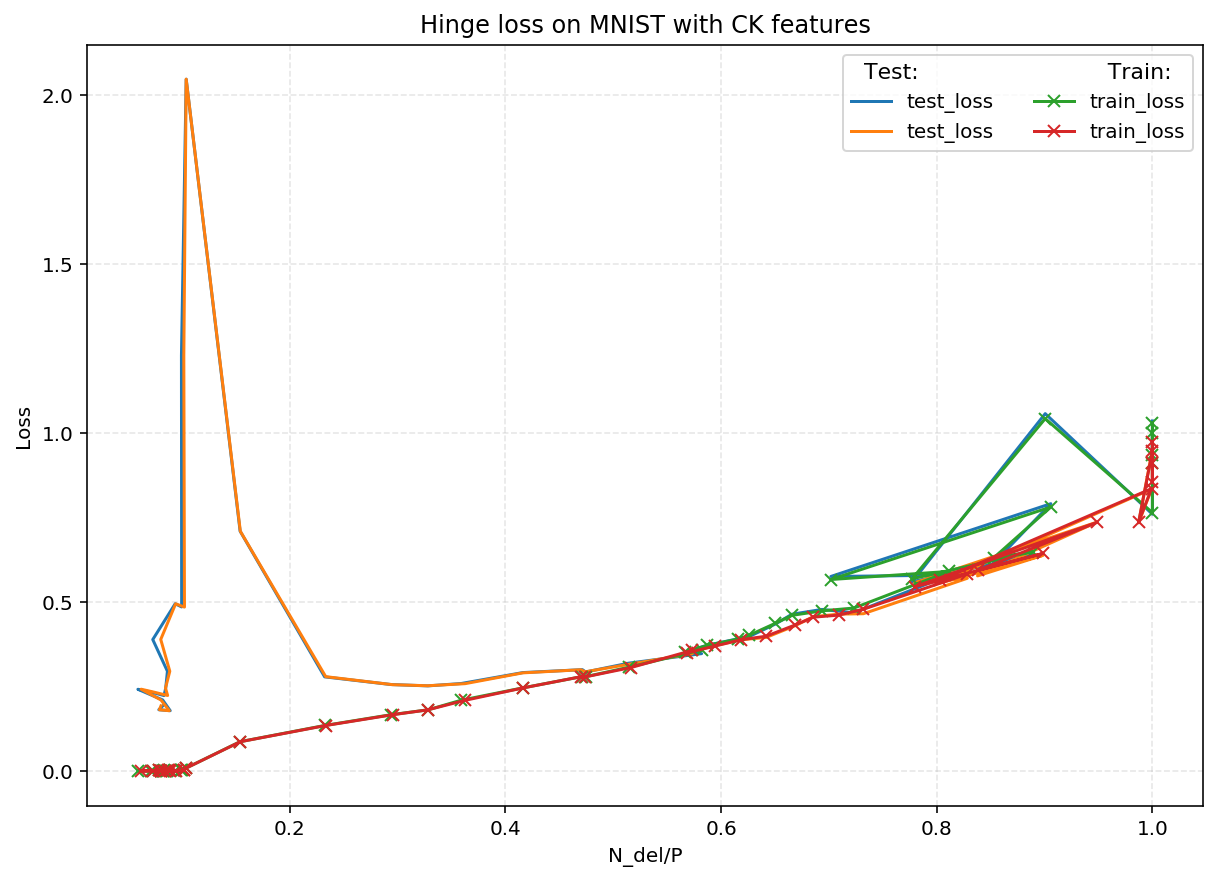

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'test_loss', ax=ax)#, kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'train_loss', ax=ax, marker='x')#, kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')

# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


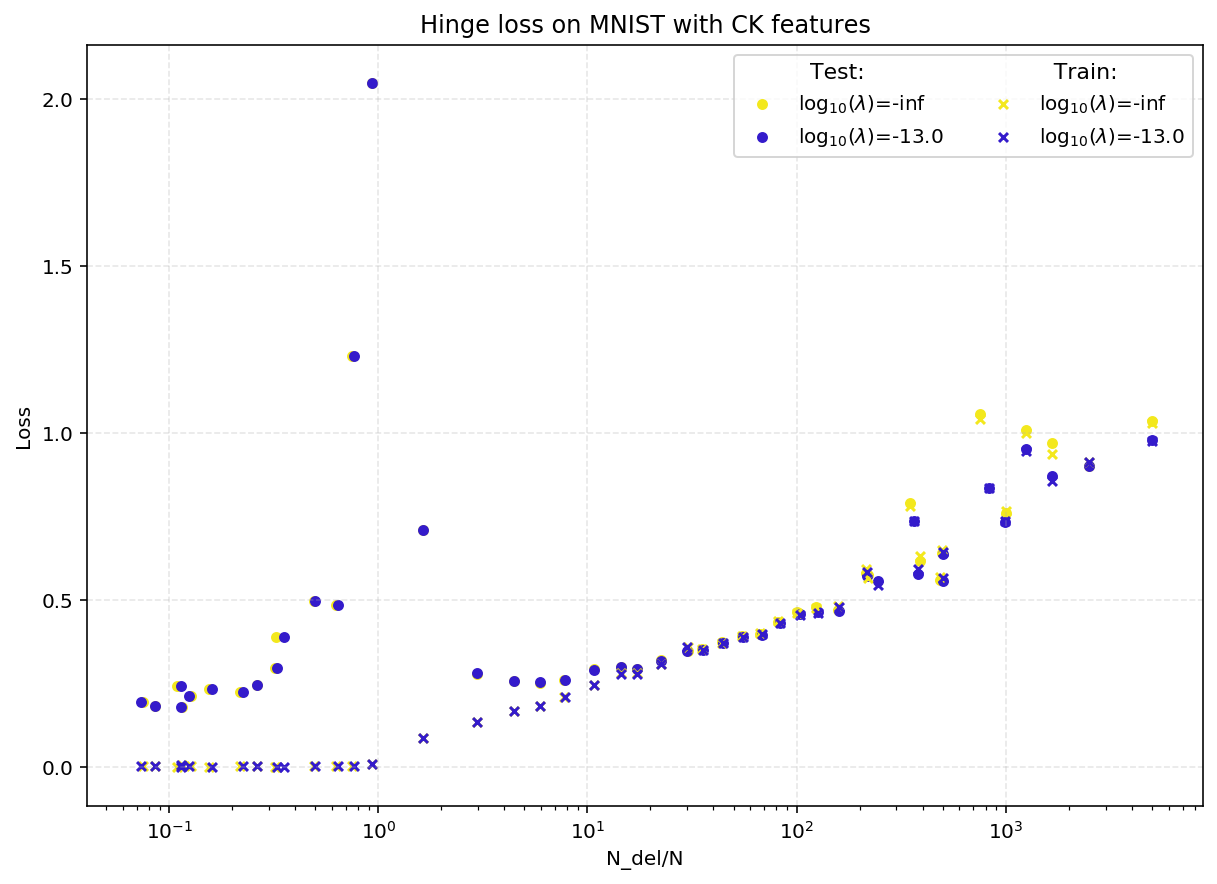

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


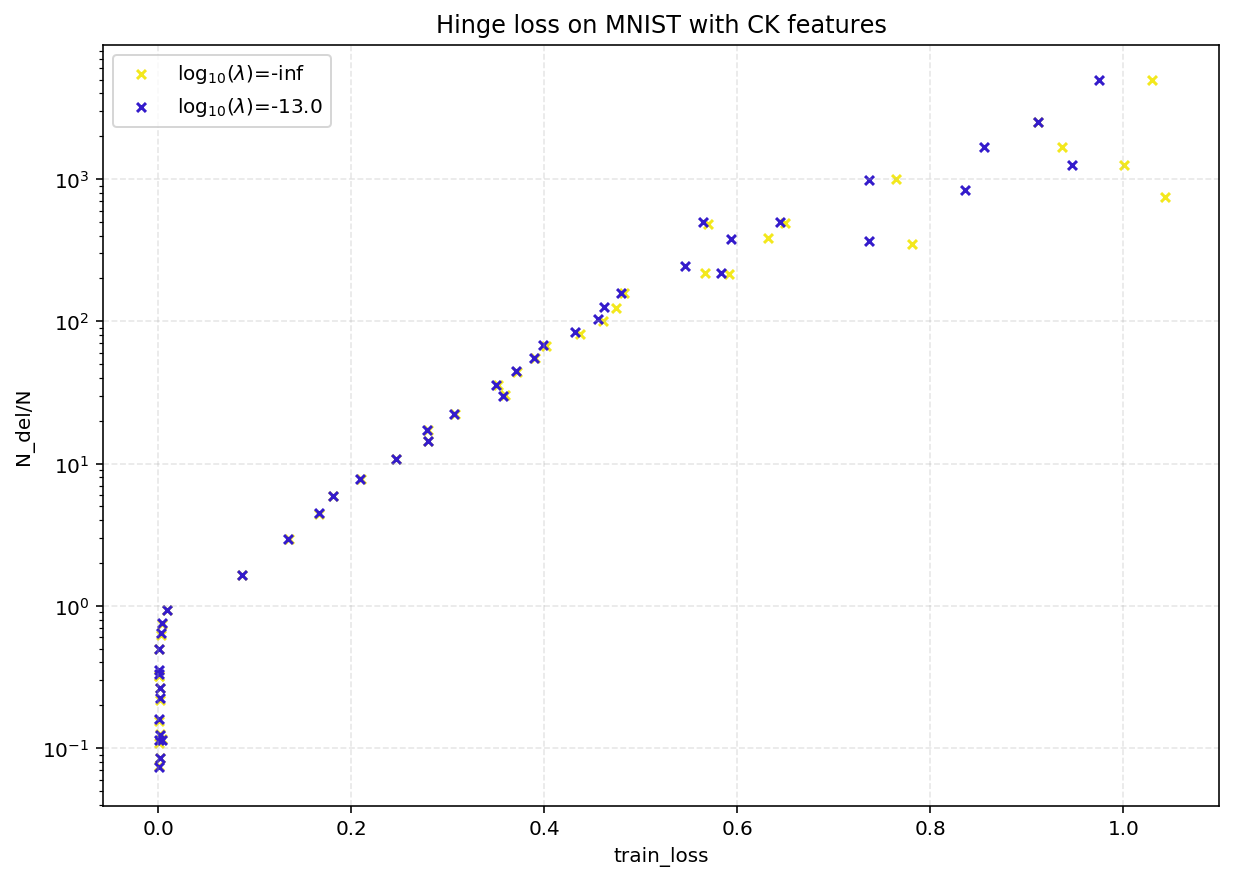

In [16]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('train_loss', 'N_del/N', ax=ax, label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


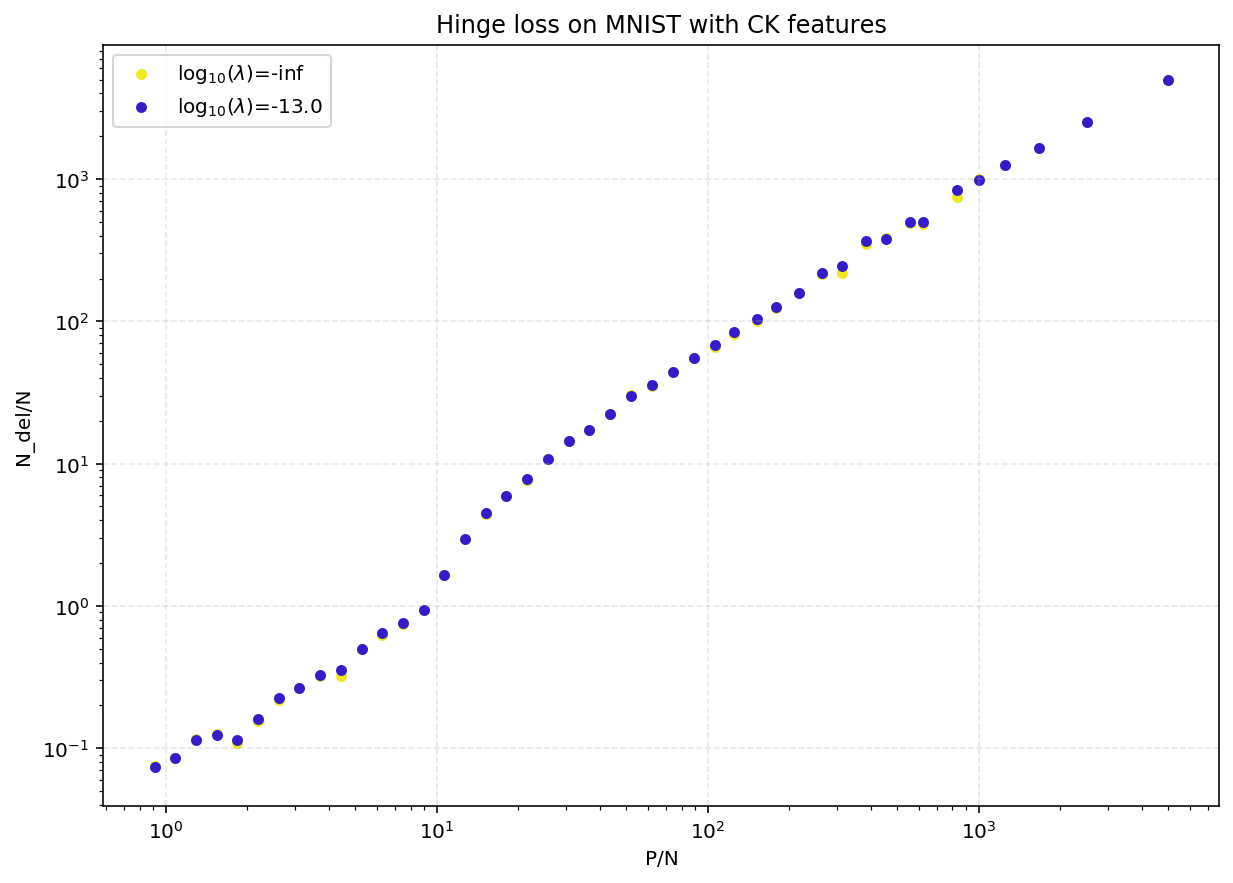

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


(0, 15)

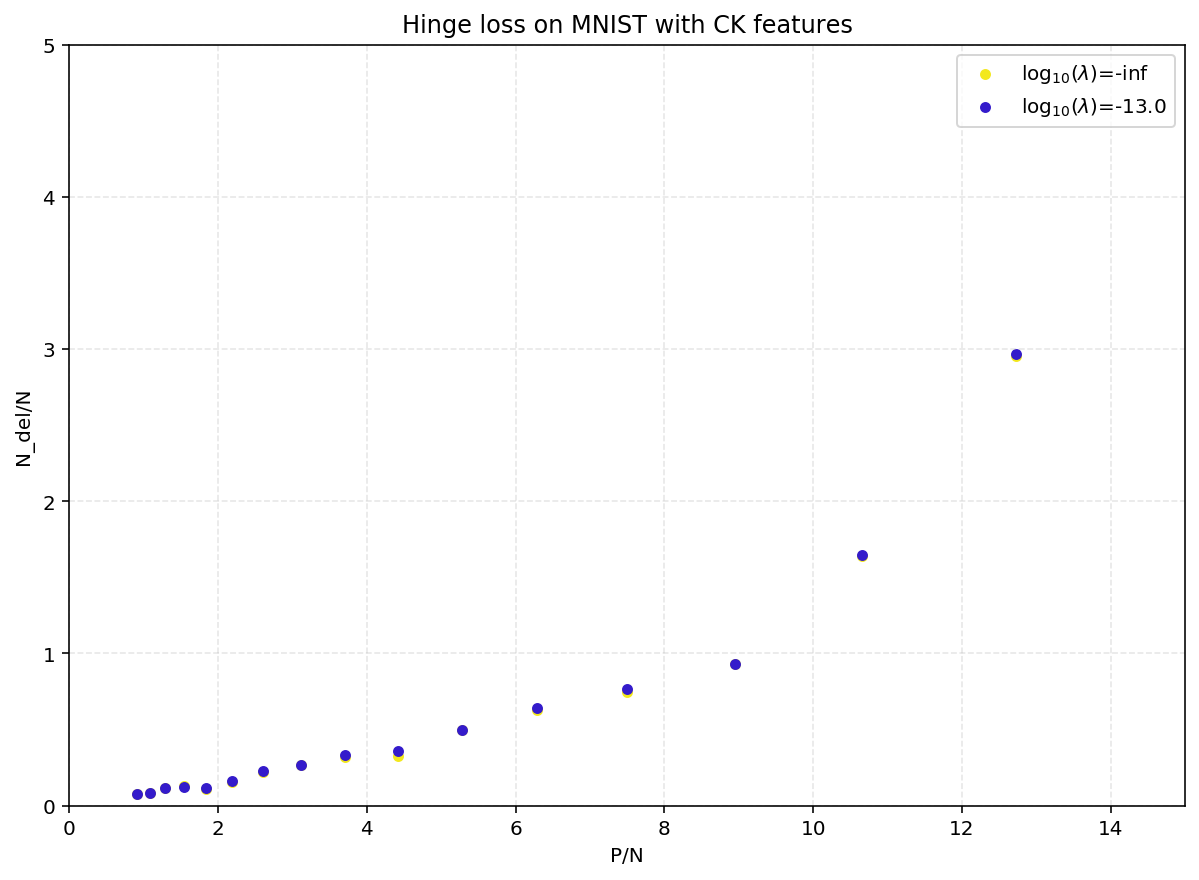

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.ylim(.0,5)
plt.xlim(0,15)
# plt.yscale('log')
